In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load data into a DataFrame
df = pd.read_csv("./Resources/working_dataset.csv").set_index("time")
df.index = pd.to_datetime(df.index)
df.head()

,Symbol,PriceUSD,Percent of Change
time,,,
2010-07-18,btc,0.085840,0
2010-07-19,btc,0.080800,0
2010-07-20,btc,0.074736,0
2010-07-21,btc,0.079193,0
2010-07-22,btc,0.058470,0


In [3]:
# Filter the dataset for only Bitcoin data, with symbol "Btc"
bitcoin = df.loc[df["Symbol"] == "btc"]
bitcoin.head()

,Symbol,PriceUSD,Percent of Change
time,,,
2010-07-18,btc,0.085840,0
2010-07-19,btc,0.080800,0
2010-07-20,btc,0.074736,0
2010-07-21,btc,0.079193,0
2010-07-22,btc,0.058470,0


In [4]:
# Check how many data points we are working with
bitcoin.count()

Symbol               4610
PriceUSD             4610
Percent of Change    4610
dtype: int64

In [5]:
# Drop unnecessary columns, focusing on the main feature which is Price [USD]
bitcoin_df = bitcoin.drop(["Symbol", "Percent of Change"], axis=1)
bitcoin_df

,PriceUSD
time,
2010-07-18,0.085840
2010-07-19,0.080800
2010-07-20,0.074736
2010-07-21,0.079193
2010-07-22,0.058470
...,...
2023-02-25,23159.815440
2023-02-26,23542.096430
2023-02-27,23504.189420


In [6]:
# Function to prepare data for training and testing
def prepare_data(data, sequence_length):
    # Normalize data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split data into training and testing sets
    training_data = scaled_data[:int(0.8*len(data)), :]
    testing_data = scaled_data[int(0.8*len(data)):, :]

    # Create sequences of data
    X_train, y_train = create_sequences(training_data, sequence_length)
    X_test, y_test = create_sequences(testing_data, sequence_length)
    # Return data and scaler object
    return X_train, y_train, X_test, y_test, scaler

In [7]:
# Function to create sliding window of sequences that will be used when splitting into training and testing sets
def create_sequences(data, sequence_length):
    X = []
    y = []
    # Loop through data with sequence_length steps at a time
    for i in range(len(data)-sequence_length-1):
        # Append a sequence of length sequence_length to X
        X.append(data[i:(i+sequence_length), :])
        # Append the next value in the sequence to y
        y.append(data[i+sequence_length, 0])
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)
    return X, y

In [8]:
# Function that builds our LSTM model, with the requirement of the input shape to be three dimensional.
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [9]:
# Prepare data
sequence_length = 30
X_train, y_train, X_test, y_test, scaler = prepare_data(bitcoin_df.values, sequence_length)

In [10]:
# Confirm if the input training set is three dimensional
print(f' X (Training) Shape: {X_train.shape}')

 X (Training) Shape: (3657, 30, 1)


In [11]:
# Build model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

In [12]:
# Train/Fit LSTM model to training data
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
58/58 [==============================] - 164s 1s/step - loss: 5.6521e-04 - val_loss: 0.0038
Epoch 2/50
58/58 [==============================] - 20s 347ms/step - loss: 8.8898e-05 - val_loss: 0.0053
Epoch 3/50
58/58 [==============================] - 32s 556ms/step - loss: 7.2027e-05 - val_loss: 0.0060
Epoch 4/50
58/58 [==============================] - 25s 436ms/step - loss: 6.3397e-05 - val_loss: 0.0153
Epoch 5/50
58/58 [==============================] - 21s 371ms/step - loss: 6.3254e-05 - val_loss: 0.0150
Epoch 6/50
58/58 [==============================] - 29s 501ms/step - loss: 5.5874e-05 - val_loss: 0.0251
Epoch 7/50
58/58 [==============================] - 31s 531ms/step - loss: 4.9045e-05 - val_loss: 0.0111
Epoch 8/50
58/58 [==============================] - 30s 526ms/step - loss: 5.1194e-05 - val_loss: 0.0144
Epoch 9/50
58/58 [==============================] - 25s 423ms/step - loss: 4.6123e-05 - val_loss: 0.0149
Epoch 10/50
58/58 [==============================] - 26s 

28/28 [==============================] - 12s 110ms/step


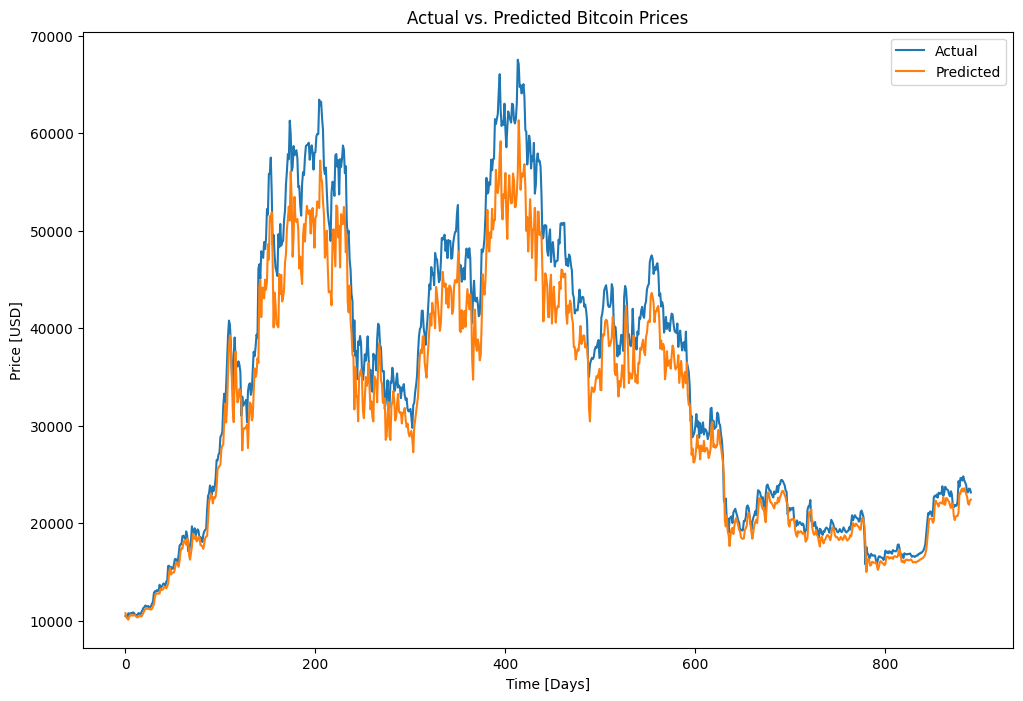

In [13]:
# Make predictions on testing data
predictions = model.predict(X_test)

# Denormalize predictions and actual values
y_pred_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12, 8))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.title('Actual vs. Predicted Bitcoin Prices')
plt.legend()
plt.show()


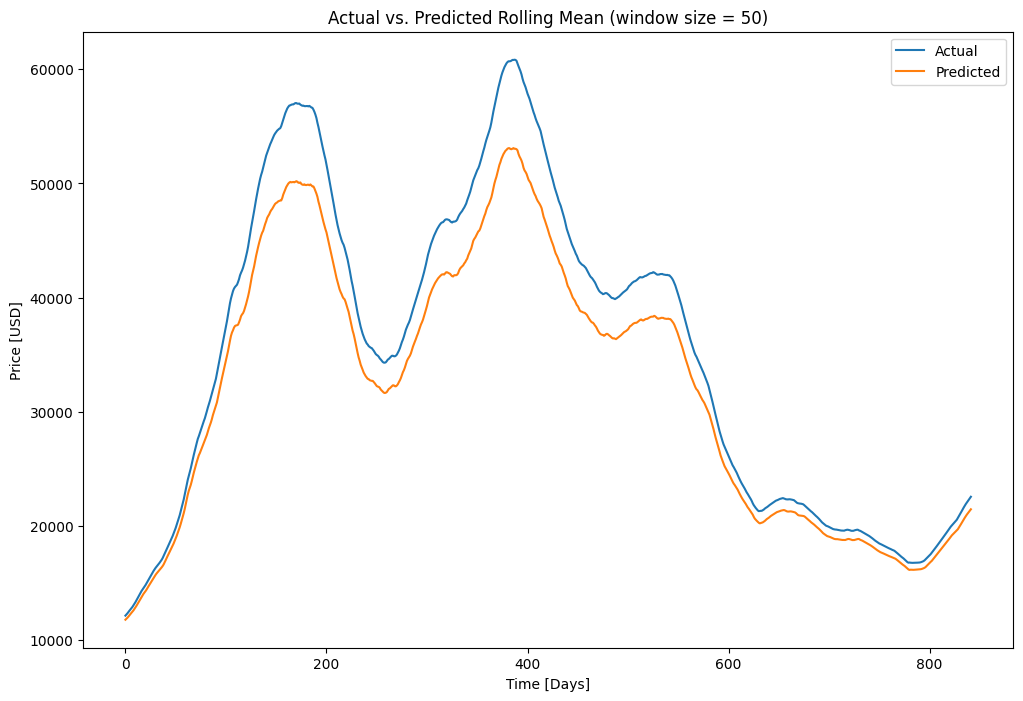

In [14]:
# Plot actual vs predicted prices with a rolling window
window_size = 50
rolling_y_test = pd.Series(y_test_inv.reshape(-1)).rolling(window_size).mean()[window_size-1:].values
rolling_y_pred = pd.Series(y_pred_inv.reshape(-1)).rolling(window_size).mean()[window_size-1:].values

plt.figure(figsize=(12, 8))
plt.plot(rolling_y_test, label='Actual')
plt.plot(rolling_y_pred, label='Predicted')
plt.title('Actual vs. Predicted Rolling Mean (window size = {})'.format(window_size))
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.legend()
plt.show()


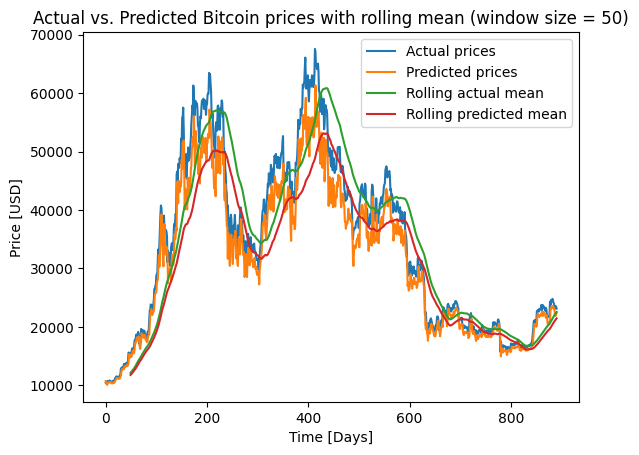

In [15]:
# Assume `y_test` is the actual Bitcoin prices and `predictions` is the predicted prices
# Convert them into pandas DataFrame for easier manipulation
y_test_df = pd.DataFrame(y_test_inv, columns=['actual'])
predictions_df = pd.DataFrame(y_pred_inv, columns=['predicted'])

# Concatenate the two DataFrames into one
results_df = pd.concat([y_test_df, predictions_df], axis=1)

# Set the window size for the rolling window
window_size = 50

# Calculate the rolling mean for both the actual and predicted prices
results_df['actual_mean'] = results_df['actual'].rolling(window_size).mean()
results_df['predicted_mean'] = results_df['predicted'].rolling(window_size).mean()

# Plot the actual and predicted prices with the rolling mean
plt.plot(results_df['actual'], label='Actual prices')
plt.plot(results_df['predicted'], label='Predicted prices')
plt.plot(results_df['actual_mean'], label='Rolling actual mean')
plt.plot(results_df['predicted_mean'], label='Rolling predicted mean')
plt.legend()
plt.title('Actual vs. Predicted Bitcoin prices with rolling mean (window size = {})'.format(window_size))
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.show()


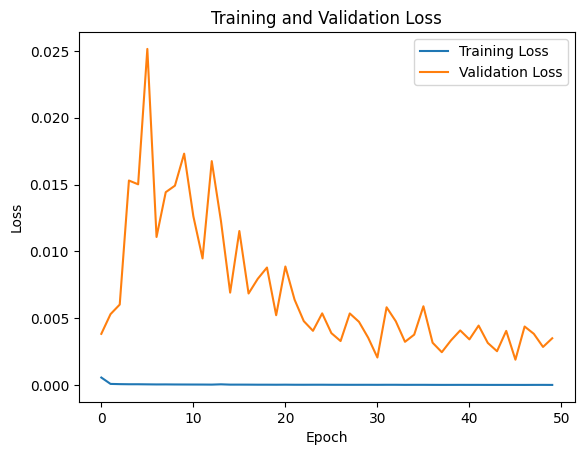

In [16]:
# Plot the training and validation loss over time/epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot a line chart of the training and validation MSE loss over the training epochs.

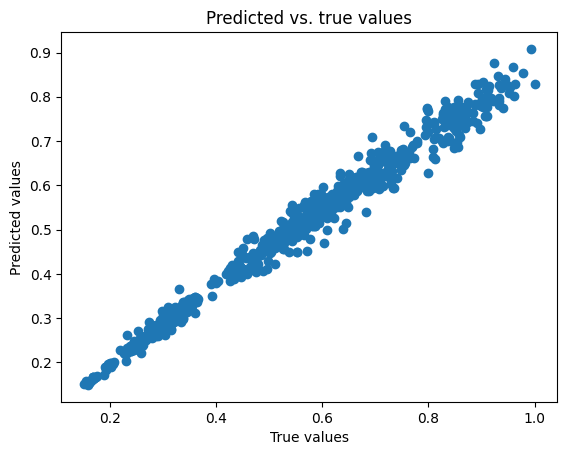

In [17]:
# Plot of the predicted values against the true values, which can help you visualize how well the model is able to predict the crypto prices.
plt.scatter(y_test, predictions)
plt.title('Predicted vs. true values')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()

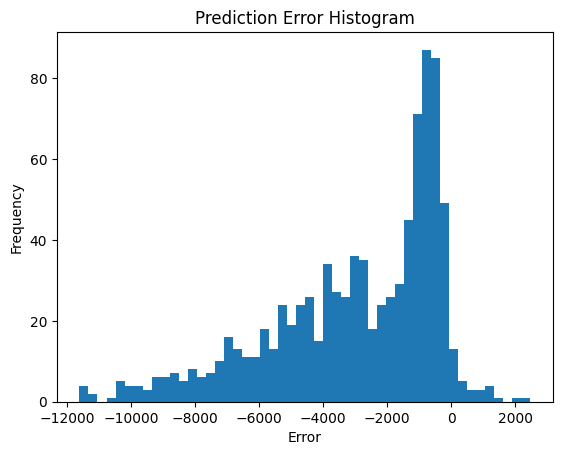

In [18]:
# Calculate prediction errors
errors = y_pred_inv - y_test_inv

# Plot histogram of errors
plt.hist(errors, bins=50)
plt.title('Prediction Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Calculate MSE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute mean absolute error
mae = mean_absolute_error(y_test, predictions)

# Compute coefficient of determination
r2 = r2_score(y_test, predictions)

# Compute mean squared error using evaluate method
mse_keras = model.evaluate(X_test, y_test)

# Calculate RMSE from MSE
rmse_keras = np.sqrt(mse_keras)

print('MSE (Keras):', mse_keras)
print('RMSE (Keras):', rmse_keras)
print('MAE:', mae)
print('R²:', r2)

28/28 [==============================] - 3s 108ms/step - loss: 0.0035
MSE (Keras): 0.003502143546938896
RMSE (Keras): 0.05917891133620908
MAE: 0.04478408726876229
R²: 0.9269076886285929


In [20]:
# Save previous predictions
previous_predictions_df = predictions_df.copy()

# Get last n rows of bitcoin_df and set index of previous_predictions_df to match
n = len(previous_predictions_df)
previous_predictions_df.index = bitcoin_df.iloc[-n:].index

In [21]:
# Use the model to predict future prices
# First, get the last sequence of data from the training set
last_sequence = X_train[-1,:,:]
# Generate the future date range
future_dates = pd.date_range(start=bitcoin_df.index[-1], periods=60, freq='D')
# Create an empty array to hold the predicted prices
predicted_prices = np.zeros((60, 1))
# Iterate over the future date range
for i, date in enumerate(future_dates):
    # Predict the price for the next day using the last sequence of data
    predicted_price = model.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
    # Add the predicted price to the array
    predicted_prices[i, 0] = predicted_price
    # Update the last sequence of data with the predicted price
    last_sequence = np.vstack((last_sequence[1:], predicted_price))

# Invert the scaling of the predicted prices
predicted_prices_inv = scaler.inverse_transform(predicted_prices)

# Create a dataframe with the predicted prices and the corresponding dates
predictions_df2 = pd.DataFrame(predicted_prices_inv, index=future_dates, columns=['predicted'])

# Print the predictions
print(predictions_df2)

1/1 [==============================] - 1s 849ms/step
               predicted
2023-03-01  11528.114128
2023-03-02  11271.069860
2023-03-03  11033.078694
2023-03-04  10807.663118
2023-03-05  10591.197901
2023-03-06  10379.393553
2023-03-07  10168.956970
2023-03-08   9958.380491
2023-03-09   9747.930825
2023-03-10   9538.949568
2023-03-11   9333.242293
2023-03-12   9132.531036
2023-03-13   8938.167457
2023-03-14   8751.125800
2023-03-15   8571.835821
2023-03-16   8400.430369
2023-03-17   8236.761497
2023-03-18   8080.610302
2023-03-19   7931.692462
2023-03-20   7789.687423
2023-03-21   7654.303314
2023-03-22   7525.229142
2023-03-23   7402.217321
2023-03-24   7284.955348
2023-03-25   7173.153365
2023-03-26   7066.532586
2023-03-27   6964.801643
2023-03-28   6867.684770
2023-03-29   6774.882547
2023-03-30   6686.168020
2023-03-31   6601.299138
2023-04-01   6520.049952
2023-04-02   6442.208103
2023-04-03   6367.573809
2023-04-04   6295.955342
2023-04-05   6227.175567
2023-04-06   6161.0689

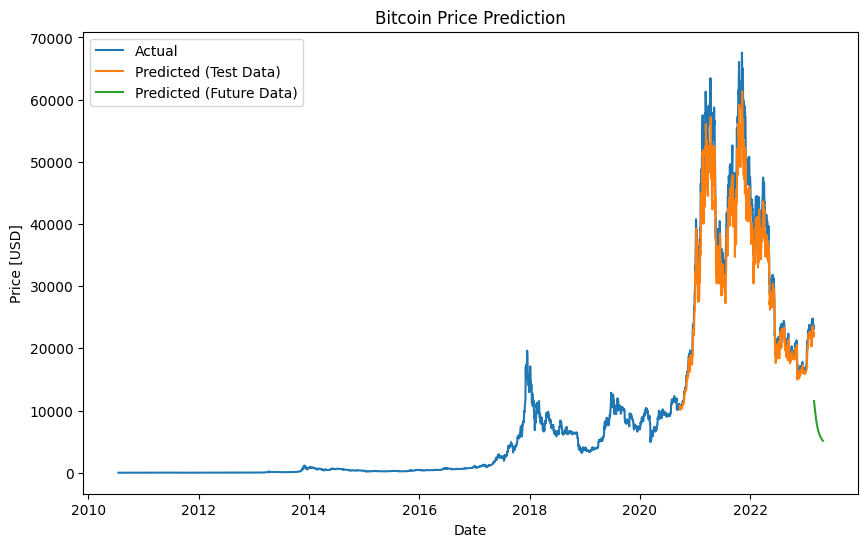

In [22]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(bitcoin_df.index, bitcoin_df.values, label='Actual')
plt.plot(previous_predictions_df.index, previous_predictions_df['predicted'], label='Predicted (Test Data)')
plt.plot(predictions_df2.index, predictions_df2['predicted'], label='Predicted (Future Data)')
plt.legend()
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.show()

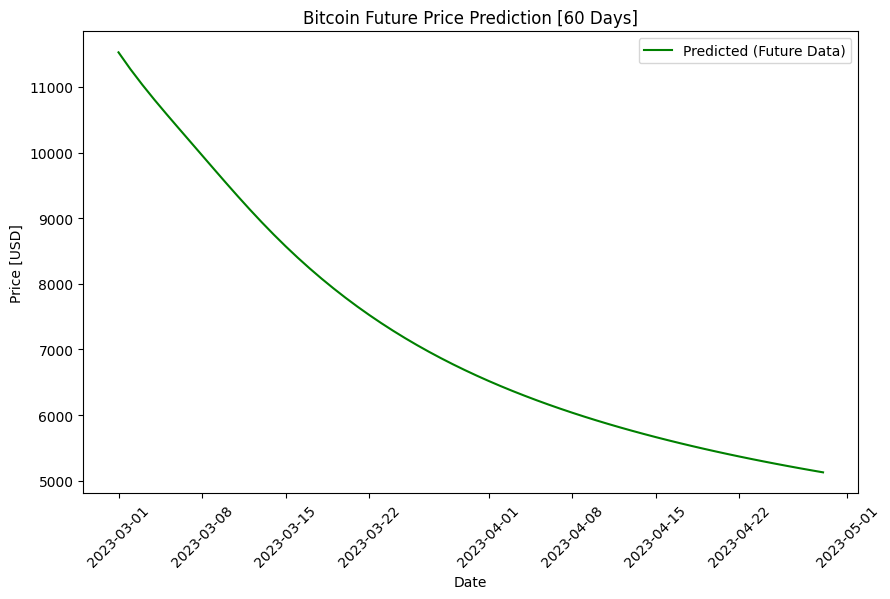

In [28]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(predictions_df2.index, predictions_df2['predicted'], color="green", label='Predicted (Future Data)')
plt.legend()
plt.title('Bitcoin Future Price Prediction [60 Days]')
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.xticks(rotation=45)
plt.show()

In [23]:
previous_predictions_df

,predicted
time,
2020-09-22,10750.969727
2020-09-23,10374.360352
2020-09-24,10263.055664
2020-09-25,10084.924805
2020-09-26,10380.952148
...,...
2023-02-25,22718.675781
2023-02-26,22014.908203
2023-02-27,21879.447266


In [24]:
predictions_df2

,predicted
2023-03-01,11528.114128
2023-03-02,11271.069860
2023-03-03,11033.078694
2023-03-04,10807.663118
2023-03-05,10591.197901
2023-03-06,10379.393553
2023-03-07,10168.956970
2023-03-08,9958.380491
2023-03-09,9747.930825
2023-03-10,9538.949568
